<span style="float: left;padding: 1.3em">![logo](https://github.com/tttiago/odw-2024/blob/main/Tutorials/logo.png?raw=1)</span>


#  Gravitational Wave Open Data Workshop #7


## Tutorial 3.2: Parameter estimation for compact object mergers

In this tutorial, we will learn how to run our own parameter estimation analysis for compact object mergers using the [bilby Bayesian inference library](https://lscsoft.docs.ligo.org/bilby/). Specifically, we will analyse the first detection, GW150914 using open data. Typically, a full analysis using stochastic sampling on a personal computer can take many hours if not days. Therefore, this analysis will be restricted to a non-spinning binary black hole model and neglect the marginalization of the calibration uncertainty. This will take about 30 minutes to run (note that a bottleneck is given by the first cell in the Section "Create a likelihood-Run the analysis": computational time depends a lot on the machine you decide to run, on Google Colab is about 10 minutes this cell only).
   
   
You can find more examples of using bilby here: https://lscsoft.docs.ligo.org/bilby/examples.html

[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/gw-odw/odw-2024/blob/main/Tutorials/Day_3/Tuto_3.2_Parameter_estimation_for_compact_object_mergers.ipynb)


##  Installation  (execute only if running on a cloud platform!)

In [19]:
# -- Use the following line in Google Colab
! pip install -q bilby==2.2.2 matplotlib==3.7.3 dynesty==2.1.2 corner==2.2.2 gwpy==3.0.8 lalsuite==7.21

**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

## Initialization

We begin by importing some commonly used functions

In [20]:
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform, PowerLaw
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries

## Bilby version

In [21]:
print(bilby.__version__)

2.2.2


## Getting the data: GW150914

In this notebook, we'll analyse GW150914. Our first task is to obtain some data!

We need to know the trigger time. This can be found on the [GWOSC page](https://www.gw-openscience.org/events/GW150914/), here we define it as a variable

In [22]:
time_of_event = 1126259462.4

### Set up empty interferometers

We need to get some data to analyse. We'll be using data from the Hanford (H1) and Livingston (L1) ground-based gravitational wave detectors. To organise ourselves, we'll create two "empty" interferometers. These are empty in the sense that they don't have any strain data. But, they know about the orientation and location of their respective namesakes. It may also be interesting to note that they are initialised with the planned design sensitivity power spectral density of advanced LIGO - we'll overwrite this later on, but it is often useful for simulations.

In [23]:
H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")

### Download the data

To analyse the signal, we need to download analysis data. Here, we will use [gwpy](https://gwpy.github.io/) to download the open strain data. For a general introduction to reading/writing data with gwpy, see [the documentation](https://gwpy.github.io/docs/stable/timeseries/).

To analyse GW150914, we will use a 4s period duration centered on the event itself. It is standard to choose the data such that it always includes a "post trigger duration" of 2s. That is, there is always 2s of data after the trigger time. We therefore define all times relative to the trigger time, duration and this post-trigger duration.

In [24]:
# Definite times in relation to the trigger time (time_of_event), duration and post_trigger_duration
post_trigger_duration = 2
duration = 4
analysis_start = time_of_event + post_trigger_duration - duration

# Use gwpy to fetch the open data
H1_analysis_data = TimeSeries.fetch_open_data(
    "H1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

L1_analysis_data = TimeSeries.fetch_open_data(
    "L1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

Here, `H1_analysis_data` and its L1 counterpart are gwpy `TimeSeries` objects. As such, we can plot the data itself out:

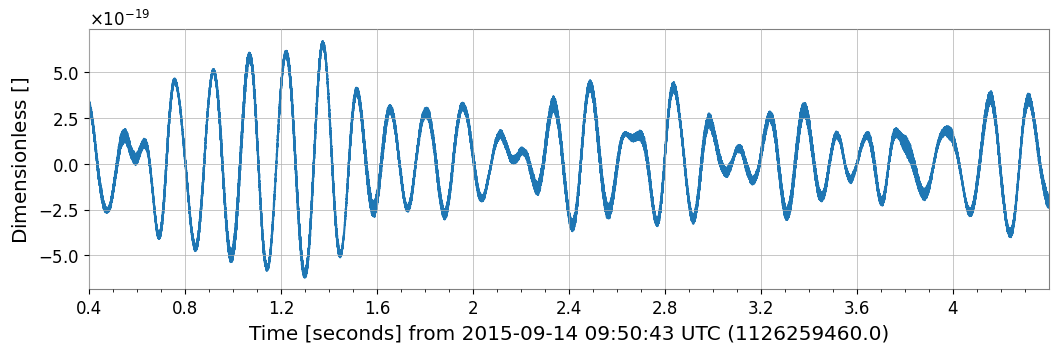

In [25]:
H1_analysis_data.plot()
plt.show()

This doesn't tell us much of course! It is dominated by the low frequency noise.

### Initialise the Bilby interferometers with the strain data

Now, we pass the downloaded strain data to our `H1` and `L1` Bilby interferometer objects. For other methods to set the strain data, see the various `set_strain_data*` methods.

In [26]:
H1.set_strain_data_from_gwpy_timeseries(H1_analysis_data)
L1.set_strain_data_from_gwpy_timeseries(L1_analysis_data)

### Download the power spectral data

Parameter estimation relies on having a power spectral density (PSD) - an estimate of the coloured noise properties of the data. Here, we will create a PSD using off-source data. For a review of methods to estimate PSDs, see, e.g. [Chatziioannou et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvD.100j4004C/abstract).

Again, we need to download this from the open strain data. We start by figuring out the amount of data needed - in this case 32 times the analysis duration. We fetch the segment with this duration immediately preceding the analysis segment.

In [27]:
psd_duration = duration * 32
psd_start_time = analysis_start - psd_duration

H1_psd_data = TimeSeries.fetch_open_data(
    "H1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

L1_psd_data = TimeSeries.fetch_open_data(
    "L1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

Having obtained the data to generate the PSD, we now use the standard [gwpy psd](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/#gwpy.timeseries.TimeSeries.psd) method to calculate the PSD. Here, the `psd_alpha` variable is converting the `roll_off` applied to the strain data into the fractional value used by `gwpy`. This applies a window with an appropriate shape to the time-domain data.

In [28]:
psd_alpha = 2 * H1.strain_data.roll_off / duration
H1_psd = H1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
L1_psd = L1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")

### Initialise the PSD
Now that we have PSDs for H1 and L1, we can overwrite the `power_spectal_density` attribute of our interferometers with a new PSD.

In [29]:
H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=L1_psd.value)

### Looking at the data
Okay, we have spent a bit of time now downloading and initializing things. Let's check that everything makes sense. To do this, we'll plot our analysis data alongside the amplitude spectral density (ASD); this is just the square root of the PSD and has the right units to be comparable to the frequency-domain strain data.

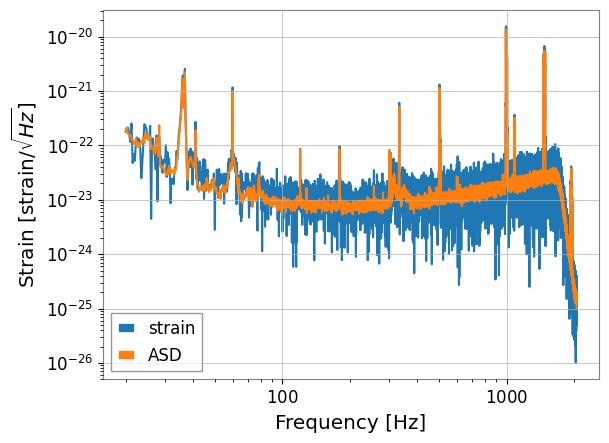

In [30]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]), label='strain')
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs], label='ASD')
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
ax.legend()
plt.show()

What is happening at high frequencies? This is an artifact of the downsampling applied to the data - note that we downloaded the 4096Hz data which is downsampled from 16384Hz. We aren't really interested in the data at these high frequencies so let's adjust the maximum frequency used in the analysis to 1024 Hz and plot things again.

In [31]:
H1.maximum_frequency = 1024
L1.maximum_frequency = 1024

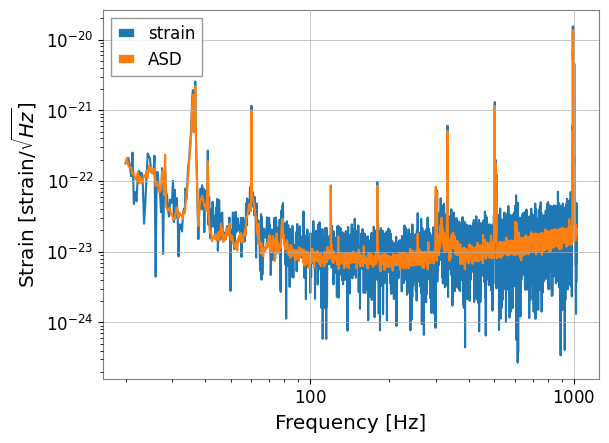

In [32]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]), label='strain')
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs], label='ASD')
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
ax.legend()
plt.show()

Okay, that is better - we now won't analyse any data near to the artifact produced by downsampling. Now we have some sensible data to analyse so let's get right on with doing the analysis!

## Low dimensional analysis

In general a compact binary coalescence signal is described by 15 parameters describing the masses, spins, orientation, and position of the two compact objects along with a time at which the signal merges. The goal of parameter estimation is to figure out what the data (and any cogent prior information) can tell us about the likely values of these parameters - this is called the "posterior distribution of the parameters".

To start with, we'll analyse the data fixing all but a few of the parameters to known values (in Bayesian lingo - we use delta function priors), this will enable us to run things in a few minutes rather than the many hours needed to do full parameter estimation.

We'll start by thinking about the mass of the system. We call the heavier black hole the primary and label its mass $m_1$ and that of the secondary (lighter) black hole $m_2$. In this way, we always define $m_1 \ge m_2$. It turns out that inferences about $m_1$ and $m_2$ are highly correlated, we'll see exactly what this means later on.

Bayesian inference methods are powerful at figuring out highly correlated posteriors. But, we can help it along by sampling in parameters which are not highly correlated. In particular, we define a new parameter called the [chirp mass](https://en.wikipedia.org/wiki/Chirp_mass) to be

$$ \mathcal{M} = \frac{(m_1 m_2)^{3/5}}{(m_1 + m_2)^{1/5}} $$

and the mass ratio

$$ q = \frac{m_{2}}{m_1} $$

If we sample (make inferences about) $\mathcal{M}$ and $q$, our code is much faster than if we use $m_1$ and $m_2$ directly! Note that so long as equivalent prior is given - one can also sample in the component masses themselves and you will get the same answer, it is just much slower!

Once we have inferred $\mathcal{M}$ and $q$, we can then derive $m_1$ and $m_2$ from the resulting samples (we'll do that in just a moment).

Okay, let's run a short (~1min on a single 2.8GHz core), low-dimensional parameter estimation analysis. This is done by defining a prior dictionary where all parameters are fixed, except those that we want to vary.

### Create a prior

Here, we create a prior fixing everything except the chirp mass, mass ratio, phase and geocent_time parameters to fixed values. The first two were described above. The second two give the phase of the system and the time at which it merges referred to the centre of the Earth (which is the standard reference considering that different detectors detect the same signal at appreciable different times, depending on the source location in the sky).

In [33]:
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=30.0,maximum=32.5)
prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.5, maximum=1)
prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-0.1, maximum=time_of_event+0.1)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = PowerLaw(alpha=2, name='luminosity_distance', minimum=50, maximum=2000, unit='Mpc', latex_label='$d_L$')


## Create a likelihood

For Bayesian inference, we need to evaluate the likelihood. In Bilby, we create a likelihood object. This is the communication interface between the sampling part of Bilby and the data. Explicitly, when Bilby is sampling it only uses the `parameters` and `log_likelihood()` of the likelihood object. This means the likelihood can be arbitrarily complicated and the sampling part of Bilby won't mind a bit!

Let's create a `GravitationalWaveTransient`, a special inbuilt method carefully designed to wrap up evaluating the likelihood of a waveform model in some data.

In [34]:
# First, put our "data" created above into a list of interferometers (the order is arbitrary)
interferometers = [H1, L1]

# Next create a dictionary of arguments which we pass into the LALSimulation waveform - we specify the waveform approximant here
waveform_arguments = dict(
    waveform_approximant='IMRPhenomXP', reference_frequency=100., catch_waveform_errors=True)

# Next, create a waveform_generator object. This wraps up some of the jobs of converting between parameters etc
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

# Finally, create our likelihood, passing in what is needed to get going
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=True, distance_marginalization=True)

14:28 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
14:28 bilby INFO    : Distance marginalisation file .distance_marginalization_lookup.npz does not exist
14:28 bilby INFO    : Building lookup table for distance marginalisation.


  0%|          | 0/400 [00:00<?, ?it/s]

Note that we also specify `time_marginalization=True`, `phase_marginalization=True`, and `distance_marginalization=True`. This is a trick often used in Bayesian inference. We analytically marginalize (integrate) over the time/phase of the system while sampling, effectively reducing the parameter space and making it easier to sample. Bilby will then figure out (after the sampling) posteriors for these marginalized parameters. For an introduction to this topic, see [Thrane & Talbot (2019)](https://arxiv.org/abs/1809.02293).

### Run the analysis

Now that the prior is set-up and the likelihood is set-up (with the data and the signal mode), we can run the sampler to get the posterior result. This function takes the likelihood and prior along with some options for how to do the sampling and how to save the data.

In [35]:
result_short = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short', label="GW150914",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    nlive=250, dlogz=1.,  # <- Arguments are used to make things fast - not recommended for general use
    clean=True,
)

14:30 bilby INFO    : Running for label 'GW150914', output will be saved to 'short'
14:30 bilby INFO    : Using lal version 7.4.1
14:30 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.21;Id: cc61d073d248e45c3c75d3732ee642448f7bc008;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
14:30 bilby INFO    : Using lalsimulation version 5.3.1
14:30 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.21;Id: cc61d073d248e45c3c75d3732ee642448f7bc008;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
14:30 bilby INFO    : Analysis priors:
14:30 bilby IN

1it [00:00, ?it/s]

14:37 bilby INFO    : Written checkpoint file short/GW150914_resume.pickle
14:37 bilby INFO    : Rejection sampling nested samples to obtain 282 posterior samples
14:37 bilby INFO    : Sampling time: 0:06:30.043336


14:37 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/282 [00:00<?, ?it/s]

14:38 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/282 [00:00<?, ?it/s]

14:38 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/282 [00:00<?, ?it/s]

14:38 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/282 [00:00<?, ?it/s]

14:39 bilby INFO    : Summary of results:
nsamples: 282
ln_noise_evidence: -8534.562
ln_evidence: -8249.997 +/-  0.207
ln_bayes_factor: 284.564 +/-  0.207



### Looking at the outputs

The `run_sampler` returned `result_short` - this is a Bilby result object. The posterior samples are stored in a [pandas data frame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) (think of this like a spreadsheet); let's take a look at it

In [36]:
result_short.posterior

,chirp_mass,mass_ratio,time_jitter,phase,geocent_time,a_1,a_2,tilt_1,tilt_2,phi_12,...,chi_2_in_plane,chi_p,cos_tilt_1,cos_tilt_2,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source
0,30.523660,0.571546,0.000118,4.494057,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.061597,268.667413,44.026270,25.163029,28.752598,69.189299
1,31.051612,0.642816,-0.000115,4.488806,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.061894,269.944403,42.098702,27.061736,29.241730,69.160438
2,30.963228,0.629020,0.000146,4.489585,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.063136,275.281941,42.407599,26.675246,29.124416,69.082845
3,30.445764,0.593067,0.000236,4.497409,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.063897,278.548143,42.974573,25.486820,28.617203,68.461393
4,31.706811,0.860724,0.000072,4.456092,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.068084,296.502043,36.776052,31.654020,29.685679,68.430072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,31.073186,0.922447,-0.000096,4.616890,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.060768,265.106321,35.040595,32.323078,29.293101,67.363673
278,31.034572,0.946716,-0.000052,1.611119,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.065020,283.366817,34.404601,32.571399,29.139891,66.975999
279,31.033430,0.982628,-0.000051,1.481088,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.064865,282.699078,33.771490,33.184803,29.143077,66.956293
280,31.043019,0.968314,-0.000034,4.764772,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.065688,286.231242,34.005023,32.927532,29.129556,66.932555


We can pull out specific parameters that we are interested in

In [37]:
result_short.posterior["chirp_mass"]

,chirp_mass
0,30.523660
1,31.051612
2,30.963228
3,30.445764
4,31.706811
...,...
277,31.073186
278,31.034572
279,31.033430
280,31.043019


This returned another `pandas` object. If you just want to get the numbers as a numpy array run

In [38]:
Mc = result_short.posterior["chirp_mass"].values

We can then get some useful quantities such as the 90\% credible interval

In [39]:
lower_bound = np.quantile(Mc, 0.05)
upper_bound = np.quantile(Mc, 0.95)
median = np.quantile(Mc, 0.5)
print("Mc = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

Mc = 31.02521065970861 with a 90% C.I = 30.5824245269549 -> 31.412647222684914


We can then plot the chirp mass in a histogram adding a region to indicate the 90\% C.I.

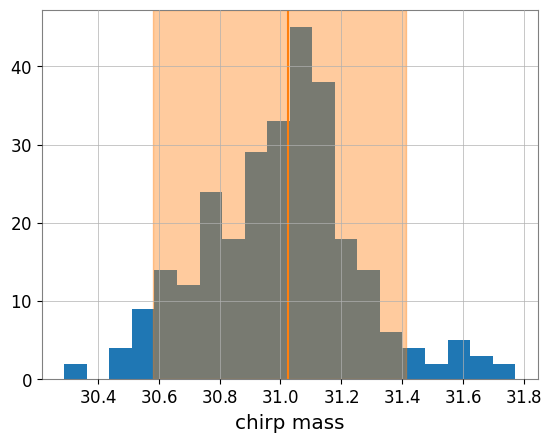

In [40]:
fig, ax = plt.subplots()
ax.hist(result_short.posterior["chirp_mass"], bins=20)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
ax.axvline(median, color='C1')
ax.set_xlabel("chirp mass")
plt.show()

The result object also has in-built methods to make nice plots such as corner plots. You can add the priors if you are only plotting parameters which you sampled in, e.g.

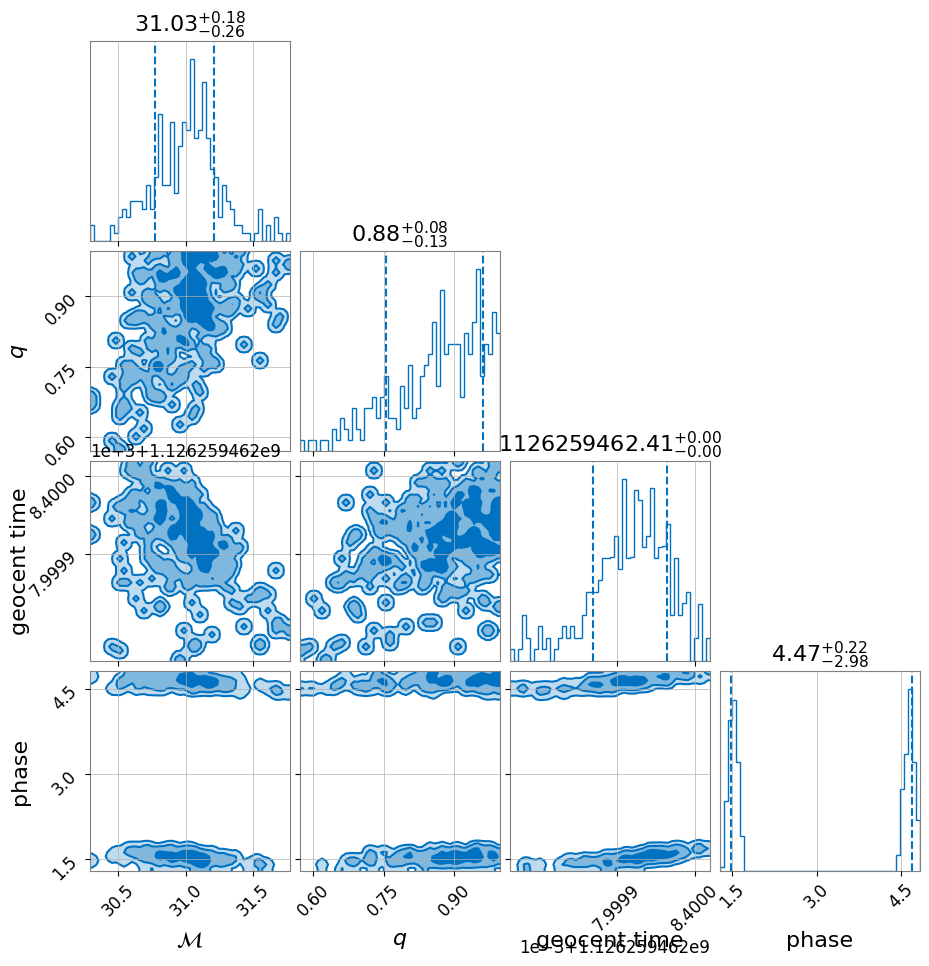

In [41]:
result_short.plot_corner(parameters=["chirp_mass", "mass_ratio", "geocent_time", "phase"], prior=True)

You can also plot lines indicating specific points. Here, we add the values recorded on [GWOSC](https://www.gw-openscience.org/events/GW150914/). Notably, these fall outside the bulk of the posterior uncertainty here. This is because we limited our prior to a non-spinning analysis - if instead we ran the full analysis these agree nicely.

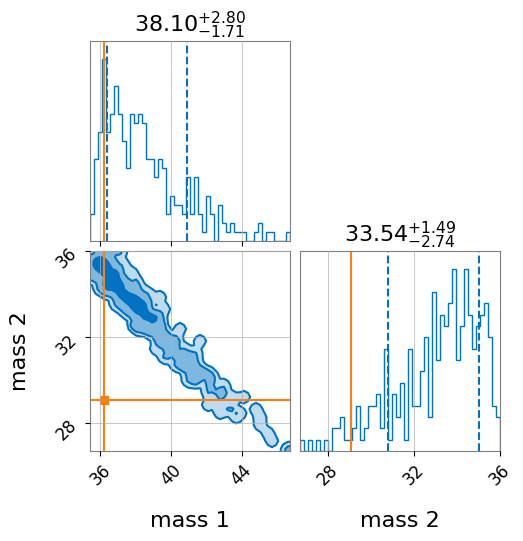

In [42]:
parameters = dict(mass_1=36.2, mass_2=29.1)
result_short.plot_corner(parameters)

Earlier we discussed the "correlation" - in this plot we start to see the correlation between $m_1$ and $m_2$.

### Meta data
The result object also stores meta data, like the priors

In [43]:
result_short.priors

{'chirp_mass': Uniform(minimum=30.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'mass_ratio': Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'phase': Uniform(minimum=0, maximum=6.283185307179586, name='phase', latex_label='$\\phi$', unit=None, boundary=None),
 'geocent_time': Uniform(minimum=1126259462.3000002, maximum=1126259462.5, name='geocent_time', latex_label='$t_c$', unit=None, boundary=None),
 'a_1': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'a_2': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'tilt_1': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'tilt_2': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'phi_12': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'phi_jl': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'dec': DeltaFunction(peak=-1.2232, name=None, 

and details of the analysis itself:

In [44]:
result_short.sampler_kwargs["nlive"]

250

Finally, we can also get out the Bayes factor for the signal vs. Gaussian noise. This is a good indicator of how much the hypothesis that the analyzed segment contains a binary black hole signal is reliable compared to that assuming it just contains noise.

In [45]:
print("ln Bayes factor = {} +/- {}".format(
    result_short.log_bayes_factor, result_short.log_evidence_err))

ln Bayes factor = 284.56446177232937 +/- 0.20667319445292948


## Challenge questions
First, let's take a closer look at the result obtained with the run above. What are the means of the chirp mass and mass ratio distributions? What are the medians of the distributions for the components masses? You can use `np.mean` and `np.median` to calculate these.

In [51]:
Mc = result_short.posterior["chirp_mass"].values
q = result_short.posterior["mass_ratio"].values
m1 = result_short.posterior["mass_1_source"].values
m2 = result_short.posterior["mass_2_source"].values

print(f"Mean chirp mass: {Mc.mean():.2f}, mean mass ratio: {q.mean():.2f}")
print(f"Median mass1: {np.median(m1):.2f}, median mass2: {np.median(m2):.2f}")

Mean chirp mass: 31.00, mean mass ratio: 0.86
Median mass1: 35.78, median mass2: 31.51


### Optional questions
Now let's expand on this example a bit. Rerun the analysis above but change the prior on the distance from a delta function to `bilby.core.prior.PowerLaw(alpha=2., minimum=50., maximum=800., name='luminosity_distance')`. You should also replace `sample='unif'` with `sample="rwalk", nact=1, walks=1` in your call to `bilby.run_sampler` above. This will take a bit longer than the original run, around ~20 minutes (something more if you are running on Colab or MyBinder). You also need to change the `label` in the call to `run_sampler` to avoid over-writing your results.

What is the median reported value of the distance posterior? What is the new log Bayes factor for signal vs. Gaussian noise? Don't be alarmed if your results do not match the official LVC results, as these are not rigorous settings.

**luminosty distribution was already power law**  
**there is not `sample='unif'` in the call to `bilby.run_sampler`**